# Исследование объявлений о продаже квартир

В вашем распоряжении архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<div style="border:solid Blue 4px; padding: 40px">

**Цель исследования**
* Определение рыночной стоимости недвижимости в зависимости от различных параметров

**Ход исследования**

О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных, проверка данных на ошибки и аномалии.
 
Таким образом, исследование пройдёт в три этапа:
 * Обзор данных.
 * Предобработка данных.
 * Проверка гипотез о влиянии параметров на стоимость объектов.

### Откройте файл с данными и изучите общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


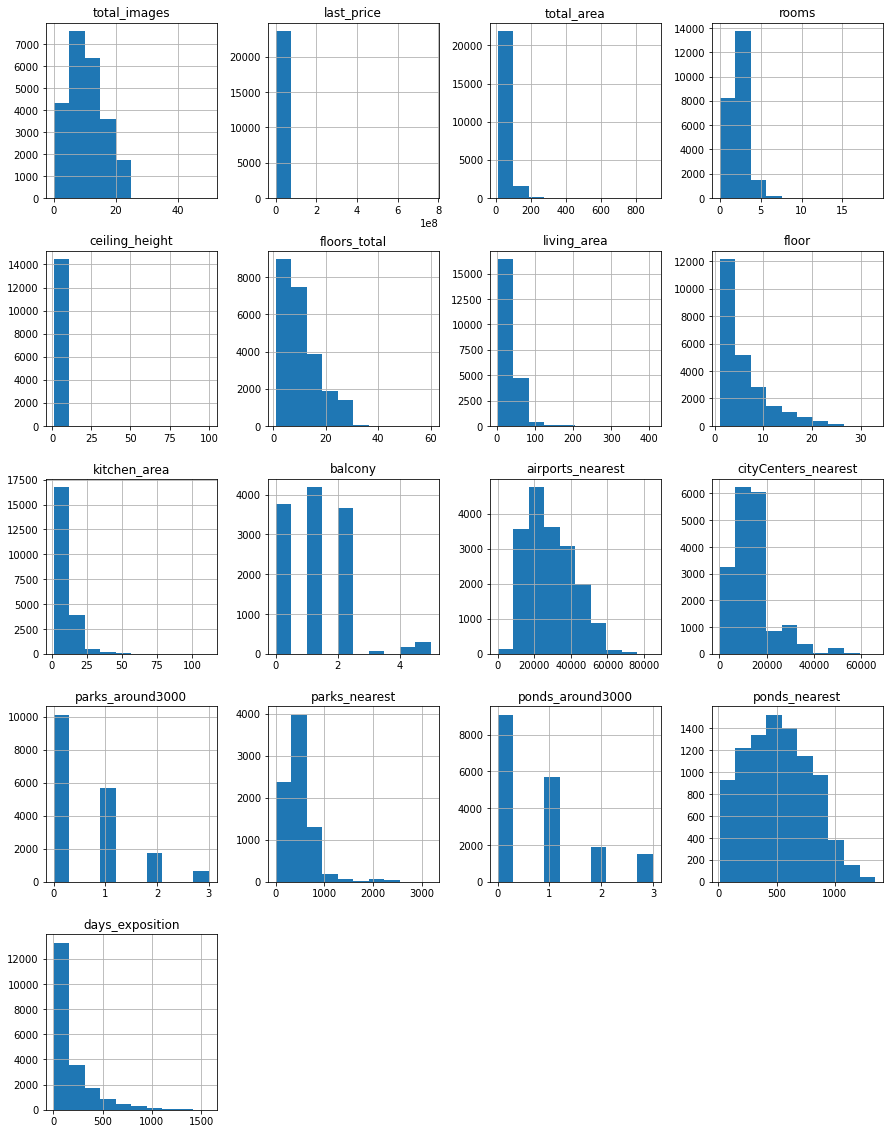

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('real_estate_data.csv',sep='\t')
    
data.info()
display(data.head())
data.hist(figsize=(15, 20))
plt.show()

### Предобработка данных

<div style="border:solid Blue 4px; padding: 40px">

**Работа с пропусками**

* Определите, в каких столбцах есть пропуски.

* Заполните пропущенные значения там, где это возможно. 

* В ячейке с типом markdown укажите причины, которые могли привести к пропускам в данных.


In [2]:
print(data.isna().sum())
#определили категории с пропусками

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


In [3]:
#для пропущенных количественных значений заменим медианнными по аналогичным объектам
area_median=data.pivot_table(index='rooms',values=['living_area','kitchen_area'],aggfunc=['median'])
area_median.columns=['living_area','kitchen_area']

for t in data['rooms'].unique():
    data.loc[(data['rooms'] == t) & (data['living_area'].isna()),'living_area'] = area_median.loc[area_median.index == t,'living_area'].values[0]
    data.loc[(data['rooms'] == t) & (data['kitchen_area'].isna()),'kitchen_area'] = area_median.loc[area_median.index == t,'kitchen_area'].values[0]

data.loc[data['ceiling_height'].isna(),'ceiling_height']=data['ceiling_height'].median()

#общее количество различных локаций
#print(data['locality_name'].value_counts())

#посчитали медианные значения там, где это возможно
parks_ponds_median=data.pivot_table(index='locality_name',values=['parks_around3000','ponds_around3000','airports_nearest','cityCenters_nearest'],aggfunc=['median'])#,dropna=False) 
parks_ponds_median.columns=['parks_around3000','ponds_around3000','airports_nearest','cityCenters_nearest']

for k in parks_ponds_median.index:
    data.loc[(data['locality_name'] == k) & (data['parks_around3000'].isna()),'parks_around3000'] = parks_ponds_median.loc[parks_ponds_median.index == k,'parks_around3000'].values[0]
    data.loc[(data['locality_name'] == k) & (data['ponds_around3000'].isna()),'ponds_around3000'] = parks_ponds_median.loc[parks_ponds_median.index == k,'ponds_around3000'].values[0]
    data.loc[(data['locality_name'] == k) & (data['airports_nearest'].isna()),'airports_nearest'] = parks_ponds_median.loc[parks_ponds_median.index == k,'airports_nearest'].values[0]
    data.loc[(data['locality_name'] == k) & (data['cityCenters_nearest'].isna()),'cityCenters_nearest'] = parks_ponds_median.loc[parks_ponds_median.index == k,'cityCenters_nearest'].values[0]

#предполагаем, что если балконы не указаны, то их нет
data.loc[data['balcony'].isna(),'balcony']=0

#можно было бы предположить, что те данные, где не указано общее число этажей-одноэтажные, но это не так
#print(data.loc[data['floors_total'].isna(),'floor'])

#если на расстоянии 3км есть парк или пруд, то как максимум ближайший парк или пруд в 3км
data.loc[(data['parks_around3000']> 0) & (data['parks_nearest'].isna()),'parks_nearest']=3000
data.loc[(data['ponds_around3000']> 0) & (data['ponds_nearest'].isna()),'ponds_nearest']=3000

#очень большое количество пропущенных значений, заполнить не получится. 
#Я бы вообще дропнула этот столбец, т.к. пропущенных значений в нем гораздо больше, чем ценных
#print(data['is_apartment'].value_counts(dropna=False))

#непонятно, чем именно можно заполнить, оставим как есть
#print(data.loc[data['days_exposition'].isna()])

#пропуск в категориальном признаке заменим на удобный для работы
data.loc[data['locality_name'].isna(),'locality_name'].fillna(value ='uncknown')

#print(data['locality_name'].value_counts())

#проверяем, что все возможные пропуски заполнились
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                14
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5394
cityCenters_nearest      5394
parks_around3000         5394
parks_nearest           15496
ponds_around3000         5394
ponds_nearest           14465
days_exposition          3181
dtype: int64


Итак, причины появления пропусков в значениях имеет смысл искать исходя из того, как именно эти значения получены. В датафрейме есть данные, **добавленные пользователем** и **картографические**. 

**Добавленные пользователями** скорее всего не были заполнены, т.к. пользователь не ответил на вопрос при заполнении, а для **картографических** возможно была ошибка выгрузки файла или какая-то человеческая ошибка при переносе информации в базу, также, возможно в данные были заведомо неполными, какими их предпочел передать заказчик.


<div style="border:solid Blue 4px; padding: 40px">
    
**Изменение типов данных**:

* Найдите столбцы, в которых нужно изменить тип данных.
 
* Преобразуйте тип данных в выбранных столбцах.

* В ячейке с типом markdown поясните, почему нужно изменить тип данных.

In [4]:
#посмотрим, какие именно типы у каждого признака
#data.info()

#изменим тип у даты
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

#для удобства чтения заменим целочисленные данные без пропущенных значений 
data['balcony']=data['balcony'].astype('int64')
data['last_price']=data['last_price'].astype('int64')
data['locality_name']=data['locality_name'].astype('str')
#проверим,что тип изменился
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23685 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

Тип данных **first_day_exposition** стоило поменять на распарсенный datetime ,т.к. в дальнейшем мы сможем извлечь необходимую информацию о конкретных частях даты, тип данных **balcony** просто удобнее читать, т.к. дробного числа балконов нет. 

Также можно было бы заменить некоторые другие данные на целочисленные (**floors_total**,**ponds_around3000**, **parks_around3000**),но пропуски не дают нам этого сделать, а **is_apartment** должен по-идее быть булевым, но опять же, пропуски осложняют ситуацию. 

<div style="border:solid Blue 4px; padding: 40px">
    
**Работа с неявными дубликатами**

* Вы можете заменить названия в существующем столбце или создать новый с названиями без дубликатов.

In [5]:
#список уникальных значений до обработки дубликатов
#print(data['locality_name'].sort_values().unique())


posyolki=[]
for x in data['locality_name'].unique():
    if ("городс" in x):
        if ('городского типа' not in x):
            data.loc[data['locality_name']==x,'locality_name']='посёлок городского типа'+x[17:]
            posyolki.append(x[17:])
        else:
            data.loc[data['locality_name']==x,'locality_name']='посёлок городского типа'+x[23:]
            posyolki.append(x[23:])
    elif ("пос" in x and "гор" not in x and "дач" not in x and "котт" not in x):
        data.loc[data['locality_name']==x,'locality_name']='посёлок'+x[7:]

for y in data['locality_name'].unique():
    if (("посёлок" in y[:7]) and (y[7:] in  posyolki)):
        data.loc[data['locality_name']==y,'locality_name']='посёлок городского типа'+y[7:]

#список уникальных значений после обработки дубликатов        
#print(data['locality_name'].sort_values().unique())            

#Думала, как сделать алгоритм получше, но в один цикл что-то у меня не вышло. Если есть какие-то фишки, было бы круто узнать)

<div style="border:solid Blue 4px; padding: 40px">
    
**Работа с выбросами и аномалиями**

* Если природа аномалии понятна и данные действительно искажены, то восстановите корректное значение.
* В противном случае удалите редкие и выбивающиеся значения.
* В ячейке с типом markdown опишите, какие особенности в данных вы обнаружили.

In [6]:
import matplotlib.pyplot as plt

#plt.ylim(2, 10)
#data.boxplot(column='ceiling_height')
#смотрим, какие значения аномальны для ceiling_height
#print(data.query('ceiling_height>10 or ceiling_height<2')['ceiling_height'].value_counts().sort_values())

for x in data.query('ceiling_height>6 or ceiling_height<2')['ceiling_height']:
    if (x>20 and x<90):
        data.loc[data['ceiling_height']==x,'ceiling_height']=x/10
    else:
        data = data.loc[data['ceiling_height']!=x]
        
#смотрим, что аномальных больше нет    
#print(data.query('ceiling_height>10')['ceiling_height'].value_counts().sort_values())

#смотрим, какие значения аномальны для last_price
#plt.ylim(0, 100)
#data['last_price'].hist(bins=10)
#print(data['last_price'].max())
#выбивающееся значение все-таки имеет высокую стоимость оправдано

#смотрим, какие значения аномальны для total_area
#plt.ylim(0, 200)
#data['total_area'].hist(bins=10)
#опять же все выглядит логично

#смотрим, какие значения аномальны для living_area
# plt.ylim(0, 40)
# data['living_area'].hist(bins=50)

#смотрим, какие значения аномальны для rooms
#plt.ylim(0, 1000)
#data['rooms'].hist()

#смотрим, какие значения аномальны для total_area
# plt.ylim(0, 60)
# data['total_area'].hist(bins=50)
# print(data['total_area'].sort_values().unique())
#нет аномальных

#смотрим, какие значения аномальны для airports_nearest
# data['airports_nearest'].hist(bins=50)
# print(data['airports_nearest'].sort_values().unique())
#т.к. в зоне аэропортов запрещена застройка
data=data.loc[data['airports_nearest']>2]



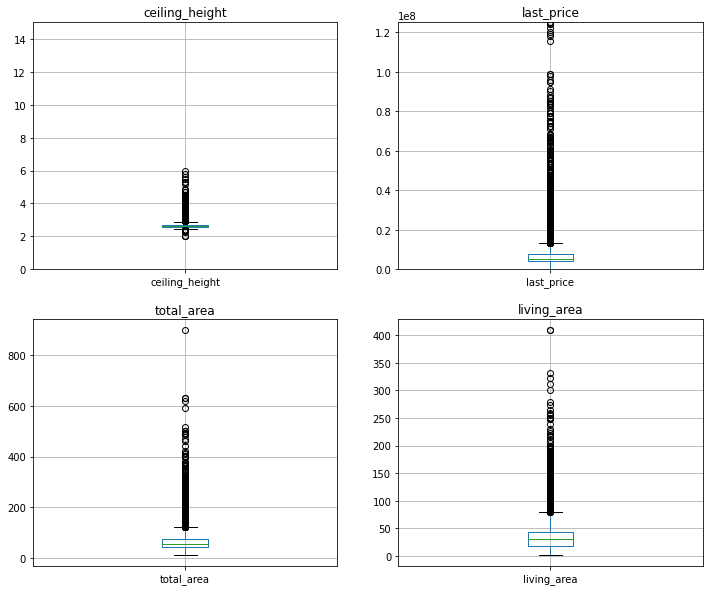

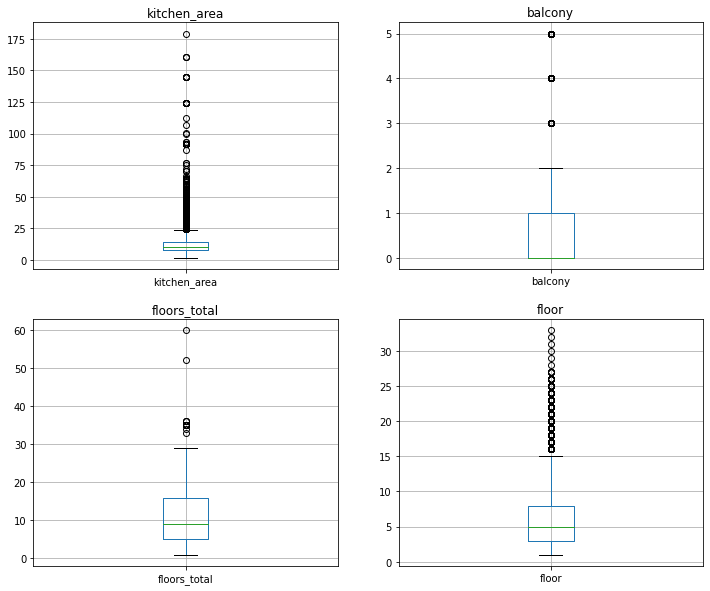

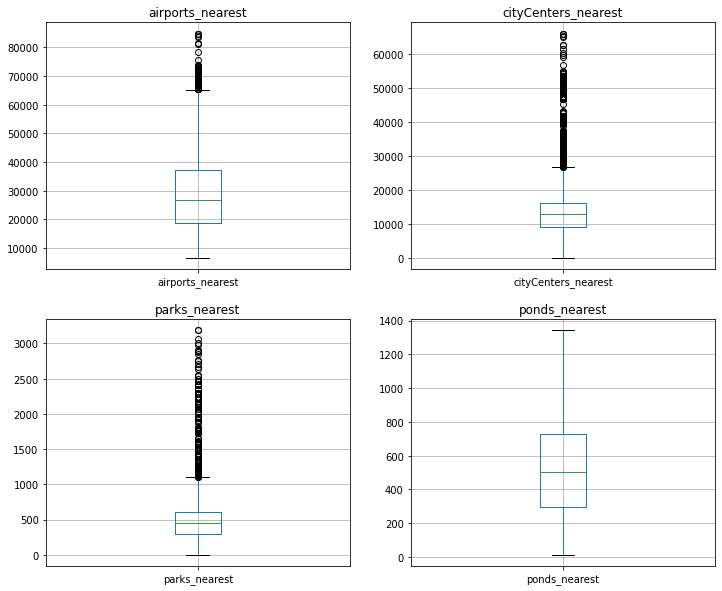

In [7]:
fig1, axs1 = plt.subplots(2, 2)
fig1.set_figwidth(12)   
fig1.set_figheight(10)

data.boxplot('ceiling_height',ax=axs1[0][0])
axs1[0][0].set_title('ceiling_height')
axs1[0][0].set_ylim(0,15)

data.boxplot('last_price',ax=axs1[0][1])
axs1[0][1].set_title('last_price')
axs1[0][1].set_ylim(0,1.25*10**8)

data.boxplot('total_area',ax=axs1[1][0])
axs1[1][0].set_title('total_area')

data.boxplot('living_area',ax=axs1[1][1])
axs1[1][1].set_title('living_area')



fig2, axs2 = plt.subplots(2, 2)
fig2.set_figwidth(12)   
fig2.set_figheight(10)

data.boxplot('kitchen_area',ax=axs2[0][0])
axs2[0][0].set_title('kitchen_area')
#axs2[0][0].set_ylim(0,15)

data.boxplot('balcony',ax=axs2[0][1])
axs2[0][1].set_title('balcony')
#axs2[0][1].set_ylim(0,1.25*10**8)

data.boxplot('floors_total',ax=axs2[1][0])
axs2[1][0].set_title('floors_total')

data.boxplot('floor',ax=axs2[1][1])
axs2[1][1].set_title('floor')


fig3, axs3 = plt.subplots(2, 2)
fig3.set_figwidth(12)   
fig3.set_figheight(10)

data.boxplot('airports_nearest',ax=axs3[0][0])
axs3[0][0].set_title('airports_nearest')

data.boxplot('cityCenters_nearest',ax=axs3[0][1])
axs3[0][1].set_title('cityCenters_nearest')
#axs2[0][1].set_ylim(0,1.25*10**8)

data.boxplot('parks_nearest',ax=axs3[1][0])
axs3[1][0].set_title('parks_nearest')

data.boxplot('ponds_nearest',ax=axs3[1][1])
axs3[1][1].set_title('ponds_nearest')

plt.show()

#data.info()

In [8]:
print(data.duplicated().sum())
#data = data.drop_duplicates()

0


### Посчитайте и добавьте в таблицу новые столбцы

<div style="border:solid Blue 4px; padding: 40px">

**Добавьте в таблицу новые столбцы со следующими параметрами:**

* цена одного квадратного метра;
* день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
* месяц публикации объявления;
* год публикации объявления;
* тип этажа квартиры (значения — «‎первый», «последний», «другой»);
* расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [9]:
data.info()
import numpy as np

data['price_per_square_meter']=np.round(data['last_price']/data['total_area'],1)

def days_categorize(date):
    try:
        return date.dayofweek
    except:
        pass
    
data['type_of_day'] = data['first_day_exposition'].apply(days_categorize)

data['month_of_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month 
data['year_of_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year 

       
def floor_categorize(floors):
    try:
        #print(floors['floor'])
        if (floors['floor']==1):
            return ('первый')
        elif (floors['floor']==floors['floors_total']):
            return ('последний')
        else:
            return ('другой')
    except:
        pass
    
data['type_of_floor'] = data.loc[:,['floor','floors_total']].apply(floor_categorize,axis=1)

data['city_center_km']=np.round(data['cityCenters_nearest']/1000) 

data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18147 entries, 0 to 23697
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          18147 non-null  int64         
 1   last_price            18147 non-null  int64         
 2   total_area            18147 non-null  float64       
 3   first_day_exposition  18147 non-null  datetime64[ns]
 4   rooms                 18147 non-null  int64         
 5   ceiling_height        18147 non-null  float64       
 6   floors_total          18071 non-null  float64       
 7   living_area           18139 non-null  float64       
 8   floor                 18147 non-null  int64         
 9   is_apartment          2143 non-null   object        
 10  studio                18147 non-null  bool          
 11  open_plan             18147 non-null  bool          
 12  kitchen_area          18147 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,type_of_day,month_of_exposition,year_of_exposition,type_of_floor,city_center_km
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,482.0,2.0,755.0,NaN,120370.4,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,NaN,0.0,NaN,81.0,82920.8,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,90.0,2.0,574.0,558.0,92785.7,3,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,2.65,14.0,9.5,9,NaN,...,84.0,3.0,234.0,424.0,408176.1,4,7,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,112.0,1.0,48.0,121.0,100000.0,1,6,2018,другой,8.0


### Проведите исследовательский анализ данных

<div style="border:solid Blue 4px; padding: 40px">


**Изучить и описать следующие параметры:**
  - общая площадь;
  - жилая площадь;
  - площадь кухни;
  - цена объекта;
  - количество комнат;
  - высота потолков;
  - этаж квартиры;
  - тип этажа квартиры («первый», «последний», «другой»);
  - общее количество этажей в доме;
  - расстояние до центра города в метрах;
  - расстояние до ближайшего аэропорта;
  - расстояние до ближайшего парка;
  - день и месяц публикации объявления

total_area
count    18147.000000
mean        63.301404
std         38.494776
min         12.000000
25%         41.200000
50%         54.000000
75%         73.000000
max        900.000000
Name: total_area, dtype: float64 

living_area
count    18139.000000
mean        34.209245
std         23.726058
min          2.000000
25%         18.000000
50%         30.000000
75%         42.800000
max        409.700000
Name: living_area, dtype: float64 

kitchen_area
count    18147.000000
mean        12.794476
std         10.386890
min          1.300000
25%          7.400000
50%         10.000000
75%         14.000000
max        179.200000
Name: kitchen_area, dtype: float64 



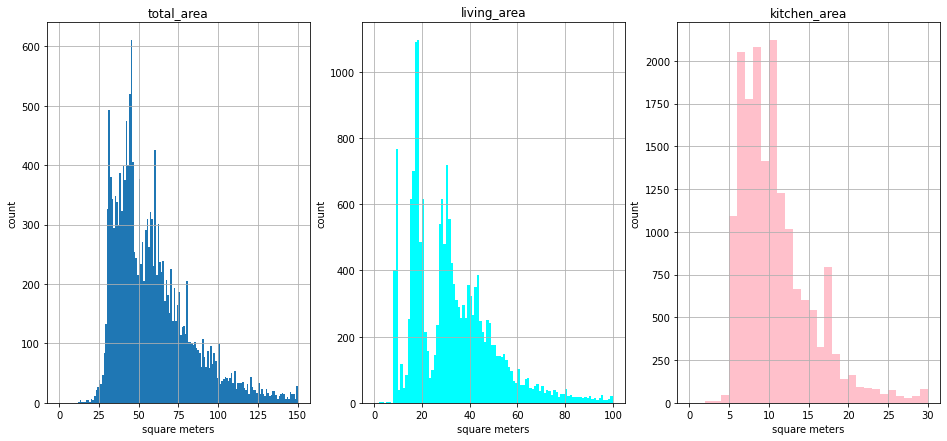

In [10]:

fig, axs = plt.subplots(1, 3)
fig.set_figwidth(16)   
fig.set_figheight(7)   

axs[0].hist(data['total_area'], bins=150,range=(0,150))#,range=(data['total_area'].min(), data['total_area'].max()))
axs[0].set_title('total_area')
axs[0].set_ylabel('count')
axs[0].set_xlabel('square meters')
#axs[0].set_xlim(0, 400)
axs[0].grid()


axs[1].hist(data['living_area'], bins=100,color='cyan',range=(0,100))
axs[1].set_title('living_area')
axs[1].set_ylabel('count')
axs[1].set_xlabel('square meters')
#axs[1].set_xlim(0, 280)
axs[1].grid()

axs[2].hist(data['kitchen_area'], bins=30,color='pink',range=(0,30))
axs[2].set_title('kitchen_area')
axs[2].set_ylabel('count')
axs[2].set_xlabel('square meters')
#axs[2].set_xlim(0, 150)
axs[2].grid()

for x in ['total_area','living_area','kitchen_area']:
    print(x)
    #print('min = ',data[x].min(),', max = ',data[x].max(),', median = ',data[x].median(),',mean = ',data[x].mean(),'\n')
    print(data[x].describe(),'\n')

Общая площадь, жилая площадь и площадь кухни - количественные переменные, распределение которых скошено вправо. Самый болльшой разброс величин наблюдается у общей площади, а самый маленький у площади кухни. 

last_price
count    1.814700e+04
mean     7.558667e+06
std      1.211578e+07
min      1.219000e+04
25%      4.000000e+06
50%      5.250000e+06
75%      7.680000e+06
max      7.630000e+08
Name: last_price, dtype: float64 

rooms
count    18147.000000
mean         2.139252
std          1.122575
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64 

ceiling_height
count    18147.000000
mean         2.712955
std          0.237864
min          2.000000
25%          2.600000
50%          2.650000
75%          2.720000
max          6.000000
Name: ceiling_height, dtype: float64 



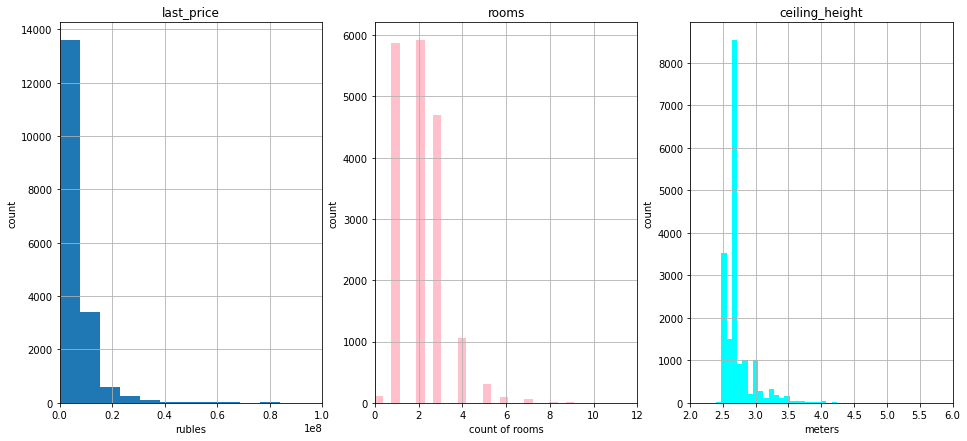

In [11]:
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(16)   
fig.set_figheight(7)   

axs[0].hist(data['last_price'], bins=100)
axs[0].set_title('last_price')
axs[0].set_ylabel('count')
axs[0].set_xlabel('rubles')
axs[0].set_xlim(0, 10**8)
axs[0].grid()


axs[1].hist(data['rooms'], bins=50,color='pink')
axs[1].set_title('rooms')
axs[1].set_ylabel('count')
axs[1].set_xlabel('count of rooms')
axs[1].set_xlim(0, 12)
axs[1].grid()

axs[2].hist(data['ceiling_height'], bins=50,color='cyan')
axs[2].set_title('ceiling_height')
axs[2].set_ylabel('count')
axs[2].set_xlabel('meters')
axs[2].set_xlim(2, 6)
axs[2].grid()


for x in ['last_price','rooms','ceiling_height']:
    print(x)
    #print('min = ',data[x].min(),', max = ',data[x].max(),', median = ',data[x].median(),'\n')
    print(data[x].describe(),'\n')
 

Последняя цена и высота потолков-количественные переменные, а количество комнат-качественная переменная. Наибольший разброс среди этих величин у цены, наименьший у высоты потолков.

floor
count    18147.000000
mean         6.134182
std          4.948853
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64 

floors_total
count    18071.000000
mean        11.166731
std          6.539018
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64 

type_of_floor
на первом этаже:  1996 , на последнем этаже:  2326 , на других этажах:  13825 



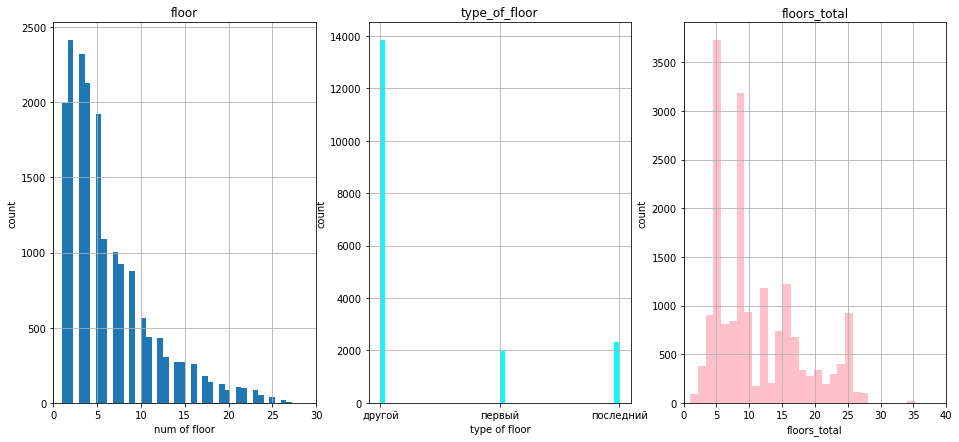

In [12]:


fig, axs = plt.subplots(1, 3)
fig.set_figwidth(16)   
fig.set_figheight(7)   

axs[0].hist(data['floor'], bins=50)
axs[0].set_title('floor')
axs[0].set_ylabel('count')
axs[0].set_xlabel('num of floor')
axs[0].set_xlim(0, 30)
axs[0].grid()


axs[1].hist(data['type_of_floor'], bins=50,color='cyan')
axs[1].set_title('type_of_floor')
axs[1].set_ylabel('count')
axs[1].set_xlabel('type of floor')
axs[1].grid()

axs[2].hist(data['floors_total'], bins=50,color='pink')
axs[2].set_title('floors_total')
axs[2].set_ylabel('count')
axs[2].set_xlabel('floors_total')
axs[2].set_xlim(0, 40)
axs[2].grid()



for x in ['floor','floors_total']:
    print(x)
    #print('min = ',data[x].min(),', max = ',data[x].max(),', median = ',data[x].median(),'\n')
    print(data[x].describe(),'\n')

print('type_of_floor')
print('на первом этаже: ',data.loc[data['type_of_floor']=='первый','type_of_floor'].count(),', на последнем этаже: ',
      data.loc[data['type_of_floor']=='последний','type_of_floor'].count(),', на других этажах: ',
      data.loc[data['type_of_floor']=='другой','type_of_floor'].count(),'\n')


Все три переменных - качественные. Наибольшее стандартное отклонение у общего количества этажей в доме.

cityCenters_nearest
count    18147.000000
mean     14194.449386
std       8613.617451
min          0.000000
25%       9234.000000
50%      13101.000000
75%      16294.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64 

airports_nearest
count    18147.000000
mean     28797.161955
std      12630.706406
min       6450.000000
25%      18585.000000
50%      26726.000000
75%      37280.500000
max      84869.000000
Name: airports_nearest, dtype: float64 

parks_nearest
count    8054.000000
mean      490.818599
std       342.550148
min         1.000000
25%       288.000000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64 



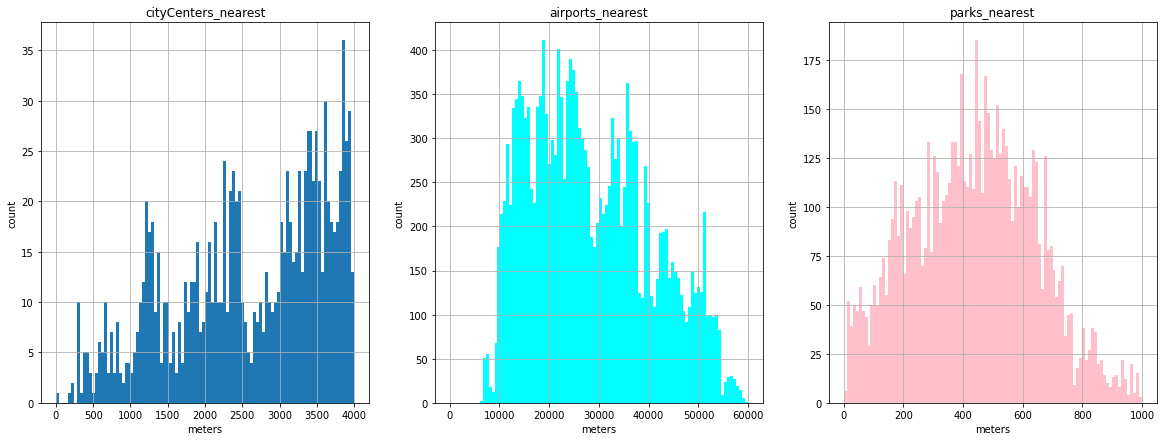

In [13]:

fig, axs = plt.subplots(1, 3)
fig.set_figwidth(20)   
fig.set_figheight(7)   

axs[0].hist(data['cityCenters_nearest'], bins=100, range=(0,4000))
axs[0].set_title('cityCenters_nearest')
axs[0].set_ylabel('count')
axs[0].set_xlabel('meters')
axs[0].grid()


axs[1].hist(data['airports_nearest'], bins=100,color='cyan',range=(0,60000))
axs[1].set_title('airports_nearest')
axs[1].set_ylabel('count')
axs[1].set_xlabel('meters')
axs[1].grid()

axs[2].hist(data['parks_nearest'], bins=100,color='pink',range=(0,1000))
axs[2].set_title('parks_nearest')
axs[2].set_ylabel('count')
axs[2].set_xlabel('meters')
axs[2].grid()


for x in ['cityCenters_nearest','airports_nearest','parks_nearest']:
    print(x)
    #print('min = ',data[x].min(),', max = ',data[x].max(),', median = ',data[x].median(),'\n')
    print(data[x].describe(),'\n')

Все три переменные количественные. Наибольший разброс у airports_nearest, наименьший у parks_nearest

type_of_day
3    3296
1    3231
4    3087
2    3048
0    2752
5    1443
6    1290
Name: type_of_day, dtype: int64 

month_of_exposition
2     2019
3     1933
11    1844
4     1840
10    1641
9     1530
8     1361
6     1354
7     1314
12    1189
1     1127
5      995
Name: month_of_exposition, dtype: int64 



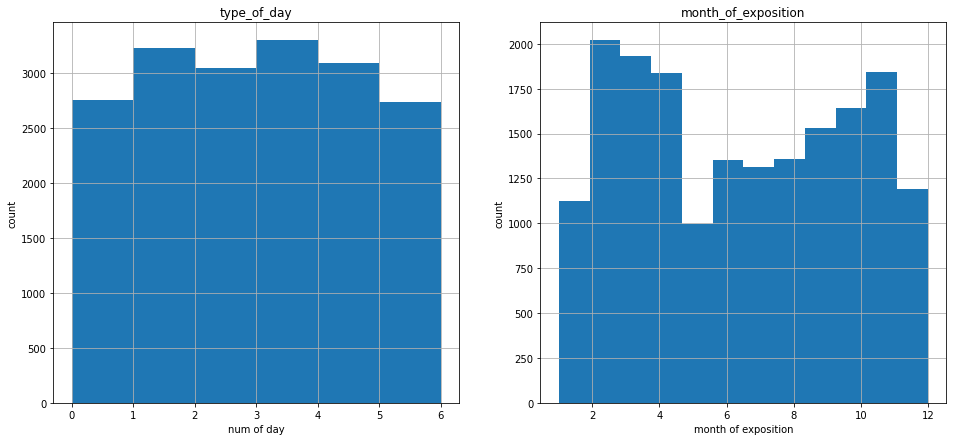

In [14]:

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(16)   
fig.set_figheight(7)   

axs[0].hist(data['type_of_day'], bins=6)
axs[0].set_title('type_of_day')
axs[0].set_ylabel('count')
axs[0].set_xlabel('num of day')
axs[0].grid()


axs[1].hist(data['month_of_exposition'], bins=12)
axs[1].set_title('month_of_exposition')
axs[1].set_ylabel('count')
axs[1].set_xlabel('month of exposition')
axs[1].grid()

for x in ['type_of_day','month_of_exposition']:
    print(x)
    print(data[x].value_counts().sort_values(ascending=False),'\n')


Обе переменные - качественные. Самый популярный день - четверг, самый популярный месяц-февраль.

<div style="border:solid Blue 4px; padding: 40px">

**Изучите, как быстро продавались квартиры**

* Постройте гистограмму.
* Посчитайте среднее и медиану.
* В ячейке типа markdown опишите, сколько времени обычно занимает продажа. 
* Какие продажи можно считать быстрыми, а какие — необычно долгими?


60.0    2.924087
45.0    2.703044
90.0    1.187318
30.0    1.181003
7.0     1.162056
4.0     0.884173
14.0    0.814703
3.0     0.814703
5.0     0.789440
9.0     0.757863
Name: days_exposition, dtype: float64
median:  96.0
count    15834.000000
mean       182.593659
std        223.360979
min          1.000000
25%         43.000000
50%         96.000000
75%        232.000000
max       1572.000000
Name: days_exposition, dtype: float64 

median:  108.0
count    14755.000000
mean       191.611522
std        228.751647
min          1.000000
25%         39.000000
50%        108.000000
75%        251.000000
max       1572.000000
Name: days_exposition, dtype: float64 

Продажи дольше, чем  562 будем считать слишком долгими
Продажи короче, чем  43 будем считать быстрыми


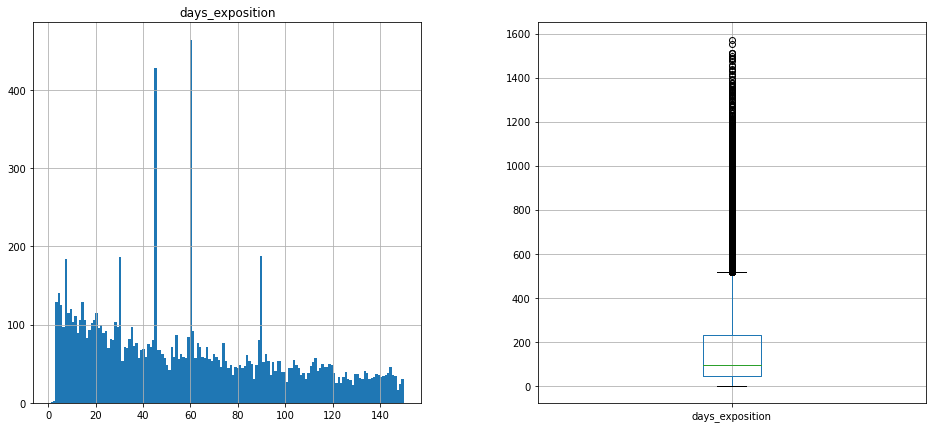

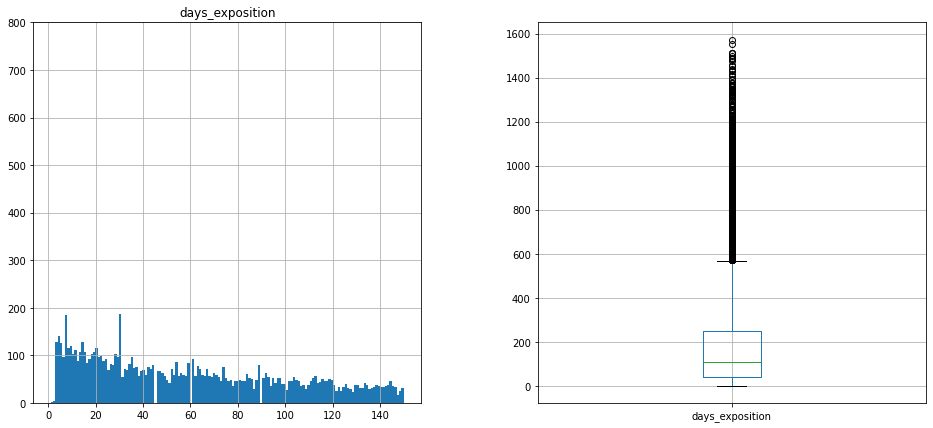

In [15]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(16)   
fig.set_figheight(7) 

#____________________________________здесь исправила код______________________________
data.hist('days_exposition',bins=150,ax=axs[0],range=(data['days_exposition'].min(), 150))
data.boxplot('days_exposition',ax=axs[1])
print(data['days_exposition'].sort_values().value_counts().head(10)/data['days_exposition'].count()*100)
popular=data['days_exposition'].sort_values().value_counts().head(3).index
#Необычно много объявлений было закрыто за 45,60 и 7 дней. Выглядит как технический сбой или работа ботов.
#посмотрим на боксплот без учета данных в эти дни

#построим новые графики
new_data=data.query('days_exposition not in @popular')
fig1, axs1 = plt.subplots(1, 2)
fig1.set_figwidth(16)   
fig1.set_figheight(7) 
new_data.hist('days_exposition',bins=150,ax=axs1[0],range=(new_data['days_exposition'].min(), 150))
new_data.boxplot('days_exposition',ax=axs1[1])
axs1[0].set_ylim(0,800)


print('median: ',data['days_exposition'].median())
print(data['days_exposition'].describe(),'\n')
too_long_old=int(232+(232-43)*1.5)
#значения выше верхнего уса
too_fast_old=45

print('median: ',new_data['days_exposition'].median())
print(new_data['days_exposition'].describe(),'\n')
too_long_new=int(252+(252-45)*1.5)
too_fast_new=43

print('Продажи дольше, чем ',too_long_new,'будем считать слишком долгими')
#значения от нижнего уса до первого квартиля
print('Продажи короче, чем ',too_fast_new,'будем считать быстрыми')

В среднем продажа занимает 183 дня. Быстрыми продажами будем считать те, что были менее, чем за 43 дня, долгими - те, что были более, чем за 515 дней.

<div style="border:solid Blue 4px; padding: 40px">

**Изучить, зависит ли цена от:**

* общей площади
* жилой площади
* площади кухни
* количества комнат
* этажа, на котором расположена квартира (первый, последний, другой)
* даты размещения (день недели, месяц, год)


Корреляция цены и общей площади:  0.6498383834033873
Корреляция цены и жилой площади:  0.5123870388896856
Корреляция цены и площади кухни:  0.36952145013491283


Text(0.5, 0, 'square meters')

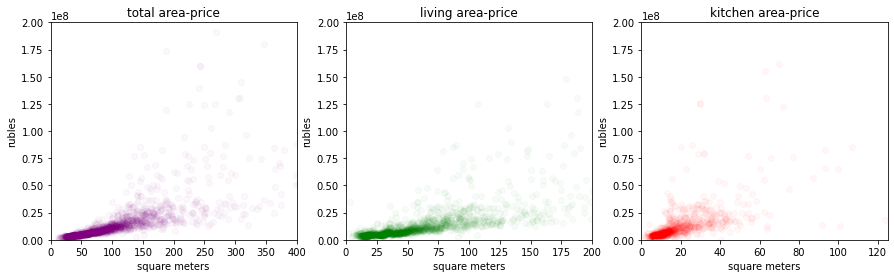

In [16]:
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(15)   
fig.set_figheight(4)

price_total_area_corr=data.pivot_table(index='total_area',values='last_price',aggfunc=['count','median'])
price_total_area_corr.columns=['num','last_price']
axs[0].scatter(price_total_area_corr.index, price_total_area_corr['last_price'],alpha=0.03,c='purple')
print('Корреляция цены и общей площади: ',data['last_price'].corr(data['total_area']))
#часть значений отбросила для более понятного отображения
axs[0].set_ylim(0,2*10**8)
axs[0].set_xlim(0,400)
axs[0].set_title('total area-price')
axs[0].set_ylabel('rubles')
axs[0].set_xlabel('square meters')

price_living_area_corr=data.pivot_table(index='living_area',values='last_price',aggfunc=['count','median'])
price_living_area_corr.columns=['num','last_price']
axs[1].scatter(price_living_area_corr.index, price_living_area_corr['last_price'],alpha=0.03,c='green')
print('Корреляция цены и жилой площади: ',data['last_price'].corr(data['living_area']))
#часть значений отбросила для более понятного отображения
axs[1].set_ylim(0,2*10**8)
axs[1].set_xlim(0,200)
axs[1].set_title('living area-price')
axs[1].set_ylabel('rubles')
axs[1].set_xlabel('square meters')

price_kitchen_area_corr=data.pivot_table(index='kitchen_area',values='last_price',aggfunc=['count','median'])
price_kitchen_area_corr.columns=['num','last_price']
axs[2].scatter(price_kitchen_area_corr.index, price_kitchen_area_corr['last_price'],alpha=0.03,c='red')
print('Корреляция цены и площади кухни: ',data['last_price'].corr(data['kitchen_area']))
#часть значений отбросила для более понятного отображения
axs[2].set_ylim(0,2*10**8)
axs[2].set_xlim(0,125)
axs[2].set_title('kitchen area-price')
axs[2].set_ylabel('rubles')
axs[2].set_xlabel('square meters')

#data.info()

Есть положительная корреляция между ценой и общей, жилой площадью и площадью кухни (что логично, т.к. эти величины чаще всего сами являются взаимозависимыми). 

Корреляция цены и количества комнат:  0.369299602762485


Text(0.5, 0, 'type of floor')

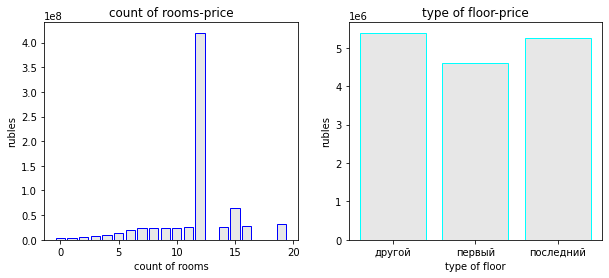

In [17]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)   
fig.set_figheight(4)

#price_rooms_corr=data.pivot_table(index='rooms',values='last_price',aggfunc='median')
price_rooms_corr=data.pivot_table(index='rooms',values='last_price',aggfunc='median')
print('Корреляция цены и количества комнат: ',data['last_price'].corr(data['rooms']))
axs[0].bar(price_rooms_corr.index,price_rooms_corr['last_price'],color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
axs[0].set_title('count of rooms-price')
axs[0].set_ylabel('rubles')
axs[0].set_xlabel('count of rooms')


price_type_of_floor_corr=data.pivot_table(index='type_of_floor',values='last_price',aggfunc='median')
axs[1].bar(price_type_of_floor_corr.index,price_type_of_floor_corr['last_price'],color=(0.1, 0.1, 0.1, 0.1),  edgecolor='cyan')
axs[1].set_title('type of floor-price')
axs[1].set_ylabel('rubles')
axs[1].set_xlabel('type of floor')





С увеличением количества комнат цена также возрастает - самая высокая цена у квартир с 12-ю комнатами, самая низкая у квартир без комнат.


 

На последних этажах квартиры в чаще стоят дороже, на первых в чаще дешевле. 

             count  last_price
type_of_day                   
3             3296     5327000
2             3048     5300000
1             3231     5299000
0             2752     5250000
4             3087     5200000
5             1443     5200000
6             1290     5150000 

                     count  last_price
month_of_exposition                   
12                    1189   5590000.0
1                     1127   5400000.0
4                     1840   5311202.5
3                     1933   5300000.0
9                     1530   5300000.0
8                     1361   5250000.0
11                    1844   5200600.0
2                     2019   5200000.0
7                     1314   5200000.0
5                      995   5150000.0
10                    1641   5100000.0
6                     1354   5000000.0 

                    count  last_price
year_of_exposition                   
2014                  115     9278000
2015                  977     5930908
2019               

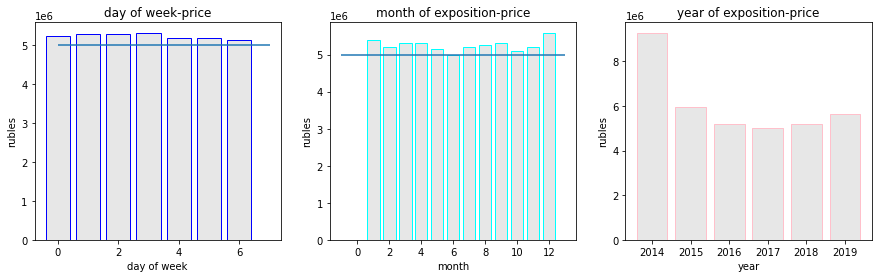

In [18]:
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(15)   
fig.set_figheight(4)

price_day_corr=data.pivot_table(index='type_of_day',values='last_price',aggfunc=['count','median'])
price_day_corr.columns=['count','last_price']
print(price_day_corr.sort_values(by='last_price',ascending=False),'\n')
axs[0].bar(price_day_corr.index,price_day_corr['last_price'],color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
axs[0].set_title('day of week-price')
axs[0].set_ylabel('rubles')
axs[0].set_xlabel('day of week')
axs[0].hlines(5*10**6, 0, 7)


price_month_corr=data.pivot_table(index='month_of_exposition',values='last_price',aggfunc=['count','median'])
price_month_corr.columns=['count','last_price']
print(price_month_corr.sort_values(by='last_price',ascending=False),'\n')
axs[1].bar(price_month_corr.index,price_month_corr['last_price'],color=(0.1, 0.1, 0.1, 0.1),  edgecolor='cyan')
axs[1].set_title('month of exposition-price')
axs[1].set_ylabel('rubles')
axs[1].set_xlabel('month')
axs[1].hlines(5*10**6, -1, 13)

price_year_corr=data.pivot_table(index='year_of_exposition',values='last_price',aggfunc=['count','median'])
price_year_corr.columns=['count','last_price']
print(price_year_corr.sort_values(by='last_price',ascending=False),'\n')
axs[2].bar(price_year_corr.index,price_year_corr['last_price'],color=(0.1, 0.1, 0.1, 0.1),  edgecolor='pink')
axs[2].set_title('year of exposition-price')
axs[2].set_ylabel('rubles')
axs[2].set_xlabel('year')

#общее количество объявлений
print(data.shape[0])



В зависимости от дня публикации самая высокая цена наблюдается у объявлений, опубликованных в четверг, а самая низкая у воскресных объявлений.

В зависимости от месяца публикации самая высокая цена наблюдается у объявлений, опубликованных в декабре, а самая низкая у июньских объявлений.

В зависимости от года-значительно дороже недвижимость была в 2014 году,однако количество объявлений в этот год всего 115, следовательно будем рассматривать выборку за исключением этого года. Самая высокая стоимость у объявлений в 2015 году, а самая низкая у объявлений в 2017г.

<div style="border:solid Blue 4px; padding: 40px">

* Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.     
* Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

In [19]:
grouped_by_locality_name=data.pivot_table(index='locality_name',values=['last_price','total_area'],aggfunc=['count','sum'])
grouped_by_locality_name.columns=['count_price','count_area','sum_price','sum_area']
grouped_by_locality_name=grouped_by_locality_name.loc[:,['count_price','sum_price','sum_area']]

grouped_by_locality_name=grouped_by_locality_name.sort_values(by='count_price',ascending=False).head(10)
grouped_by_locality_name['price_per_one_meter']=np.round(grouped_by_locality_name['sum_price']/grouped_by_locality_name['sum_area'],1)
display(grouped_by_locality_name)

print(grouped_by_locality_name.query('price_per_one_meter == price_per_one_meter.max()').index)
print(grouped_by_locality_name.query('price_per_one_meter == price_per_one_meter.min()').index)

,count_price,sum_price,sum_area,price_per_one_meter
locality_name,,,,
Санкт-Петербург,15627,125278506062,1009317.41,124122.0
посёлок Шушары,436,1794455999,23546.36,76209.5
Пушкин,369,2387074264,22712.98,105097.4
Колпино,337,1336889246,17956.64,74451.0
посёлок Парголово,327,1467600459,16847.50,87110.9
Петергоф,201,889192000,10397.15,85522.7
Сестрорецк,183,1160535140,11596.16,100079.3
Красное Село,175,668796000,9638.60,69387.3
Ломоносов,132,483563000,6766.20,71467.4


Index(['Санкт-Петербург'], dtype='object', name='locality_name')
Index(['Красное Село'], dtype='object', name='locality_name')


<div style="border:solid Blue 4px; padding: 40px">

* Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. 

* Опишите, как стоимость объектов зависит от расстояния до центра города.

[]

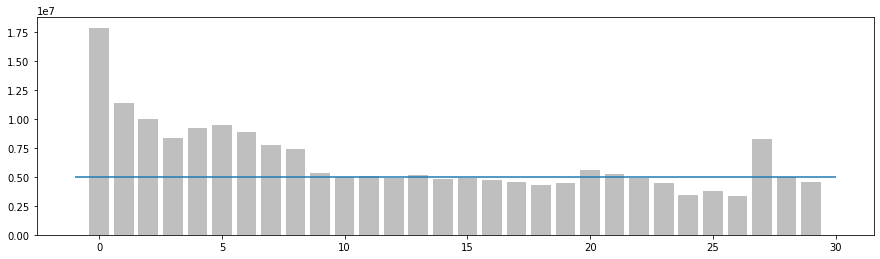

In [20]:
fig, axs = plt.subplots()
fig.set_figwidth(15)   
fig.set_figheight(4)

spb_data=data.query('locality_name=="Санкт-Петербург"')
price_per_city_center_distance=spb_data.pivot_table(index='city_center_km',values='last_price',aggfunc='median')
price_per_city_center_distance.columns=['price']
price_per_city_center_distance=price_per_city_center_distance.sort_values(by='price')
#print(price_per_city_center_distance)

axs.bar(price_per_city_center_distance.index,price_per_city_center_distance['price'],color=(0.5, 0.5, 0.5, 0.5))
axs.hlines(price_per_city_center_distance['price'].median(), -1, 30)
plt.plot(title = 'Заголовок')

В центре города располагаются самые дорогие объекты недвижимости, при удалении от центра наблюдается снижение цены, однако на 27км от центра наблюдается увеличение цены до 5-6км зоны удаленности от центра.

### Общий вывод

На стоимость недвижимости влияет множество различных факторов. Например, регион расположения недвижимости - в данной выборке в Санкт-Петербурге самая высокая цена за квадратный метр. Чем более удалена от центра недвижимость, тем ниже стоимость за квадратный метр.
На первых этажах квартира будет стоить ниже, а на последних скорее выше, чем на прочих. Стоимость квартиры увеличивается с увеличением общего количества комнат, общей, жилой площади и площади кухни. Двенадцатикомнатные квартиры - самые дорогие, а студии самые дешевые.Наиболее высокая цена наблюдается у объявлений, опубликованных в декабре, а наиболее низкая у объявлений, опубликованных в июне.Среднее время продажи недвижимости - В среднем продажа занимает 183 дня.


<div style="border:solid Blue 4px; padding: 40px">
Задачей исследования было определение зависимости рыночной стоимости недвижимости от различных параметров. 

В ходе исследования были изучены предоставленные данные, произведена их предобработка (произведена проверка на пропуски и дубликаты в данных, найдены и устранены аномалии), для каждого параметра датафрейма были построены визуализации, показывающие распределение данных, а также выведены основные параметры (минимальные, максимальные значения и медиана). Затем было рассмотрено влияние отдельно взятых параметров на стоимость объекта недвижимости. По итогу рассмотрения получены и визуализированы следующие выводы этой взаимосвязи:

* **общая площадь**: чем выше общая площадь объекта, тем выше цена на него
* **жилая площадь**: чем выше жилая площадь объекта, тем выше цена на него
* **площадь кухни**: чем выше площадь кухни объекта, тем выше цена на него. При этом из этих трех параметров сильнее всего цена зависит от общей площади, а меньше всего от площади кухни.

* **количество комнат**: чем больше комнат, тем выше цена на объект. не смотря на это самые дорогие объекты недвижимости - двенадцатикомнатные, а самые дешевые - студии.
* **тип этажа**: стоимость объекта ниже, если он расположен на первом этаже.
* **день недели публикации**: стоимость объявлений, опубликованных в четверг в среднем выше, а у воскресных в среднем ниже.
* **месяц публикации**: наибольшая стоимость наблюдается у объявлений, опубликованных в декабре, а наименьшая - в июне.
* **год публикации**: наибольшая стоимость недвижимости была в 2015,затем последовал спад стоимостей. Рынок начал расти только начиная с 2018г.

Помимо прочего стоимость объекта зависит от его местоположения. Самые высокие цены на недвижимость в данной выборке - в Санкт-Петербугре. Он был рассмотрен отдельно  для выявления взаимосвязи стоимости объекта и его удаленности от центра города. Наибольшую стоимость имеют объекты, расположенные в центре города, а также в пределах 6км от него, а также объекты на удалении 27км от центра.


____________________
Рекомендации: При получении данных от пользователей или картографически  следует проверять, что все поля заполнены корректно. Практически повсеместно не заполнено поле is_apartment - стоит проверить, верно ли работает способ получения этого параметра. Возможно, что для количества балконов имеет смысл добавить опцию "отсутствуют" - таким образом можно сократить пропуски в данных и не потерять ценную информацию об объектах. Помимо прочего, некоторые картографические данные были пропущены, в связи с чем стоит проверить, не происходят ли какие-либо технические сбои или ошибки переноса данных.
    
При формировании рыночной стоимости объекта стоит ориентироваться на такие параметры как общая,жилая площадь и площадь кухни, количество комнат, регион расположения объекта, его удаленность от центра (для больших городов), а также этажа расположения объекта.
